# Think Bayes

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

from thinkbayes2 import MakePoissonPmf, EvalBinomialPmf, MakeMixture

import thinkplot

## Cats and rats and elephants

Suppose there are six species that might be in a zoo: lions and tigers and bears, and cats and rats and elephants.  Every zoo has a subset of these species, and every subset is equally likely.

One day we visit a zoo and see 3 lions, 2 tigers, and one bear.  Assuming that every animal in the zoo has an equal chance to be seen, what is the probability that the next animal we see is an elephant?



## Solution

I'll start by enumerating all possible zoos with `itertools`.

In [2]:
from itertools import combinations

def power_set(s):
    n = len(s)
    for r in range(1, n+1):
        for combo in combinations(s, r):
            yield ''.join(combo)

Now we can enumerate only the zoos that are possible, given a set of animals known to be present.

In [3]:
def enumerate_zoos(all_species, present):
    """Enumerate all zoos that contain `present`.
    
    all_species: sequence of all species
    present: sequence of species present
    
    yields: possible zoos
    """
    present = set(present)
    for combo in power_set(species):
        intersect = set(combo) & present
        if len(intersect) == len(present):
            yield len(combo), combo

Here are the possible zoos.

In [4]:
species = 'LTBCRE'
present = 'LTB'

for n, zoo in enumerate_zoos(species, present):
    print(n, zoo)

3 LTB
4 LTBC
4 LTBR
4 LTBE
5 LTBCR
5 LTBCE
5 LTBRE
6 LTBCRE


To represent the prior and posterior distributions I'll use a hierarchical model with one Dirichlet object for each possible zoo.

At the bottom of the hierarchy, it is easy to update each Dirichlet object just by adding the observed frequencies to the parameters.

In order to update the top of the hierarchy, we need the total probability of the data for each hypothetical zoo.  When we do an update using grid algorithms, we get the probability of the data free, since it is the normalizing constant.

But when we do an update using a conjugate distribution, we don't get the total probability of the data, and for a Dirichlet distribution it is not easy to compute.

However, we can estimate it by drawing samples from the Dirichlet distribution, and then computing the probability of the data for each sample.

In [5]:
class Dirichlet(object):
    """Represents a Dirichlet distribution.

    See http://en.wikipedia.org/wiki/Dirichlet_distribution
    """

    def __init__(self, n, conc=1, label=None):
        """Initializes a Dirichlet distribution.

        n: number of dimensions
        conc: concentration parameter (smaller yields more concentration)
        label: string label
        """
        if n < 2:
            raise ValueError('A Dirichlet distribution with '
                             'n<2 makes no sense')

        self.n = n
        self.params = np.ones(n, dtype=np.float) * conc
        self.label = label if label is not None else '_nolegend_'

    def update(self, data):
        """Updates a Dirichlet distribution.

        data: sequence of observations, in order corresponding to params
        """
        m = len(data)
        self.params[:m] += data

    def random(self):
        """Generates a random variate from this distribution.

        Returns: normalized vector of fractions
        """
        p = np.random.gamma(self.params)
        return p / p.sum()

    def mean(self):
        """Array of means."""
        return self.params / self.params.sum()

Here's an example that represents a zoo with 4 animals.

In [6]:
d4 = Dirichlet(4)

Here's a sample from it.

In [7]:
p = d4.random()

array([0.22243685, 0.13145446, 0.59255112, 0.05355757])

Now we can compute the probability of the data, given these prevalences, using the multinomial distribution.

In [8]:
from scipy.stats import multinomial

data = [3, 2, 1, 0]
m = sum(data)
multinomial(m, p).pmf(data)

0.006761575978171484

Since I only observed 3 species, and my hypothetical zoo has 4, I had to zero-pad the data.  Here's a function that makes that easier:

In [9]:
def zero_pad(a, n):
    """Why does np.pad have to be so complicated?
    """
    res = np.zeros(n)
    res[:len(a)] = a
    return res

Here's an example:

In [10]:
data = [3, 2, 1]
zero_pad(data, 4)

array([3., 2., 1., 0.])

Let's pull all that together.  Here's a function that estimates the total probability of the data by sampling from the dirichlet distribution:

In [11]:
def sample_likelihood(dirichlet, data, iters=1000):
    """Estimate the total probability of the data.
    
    dirichlet: Dirichlet object
    data: array of observed frequencies
    iters: number of samples to draw
    """
    data = zero_pad(data, dirichlet.n)
    m = np.sum(data)
    likes = [multinomial(m, dirichlet.random()).pmf(data) 
             for i in range(iters)]
    return np.mean(likes)

And here's an example:

In [12]:
sample_likelihood(d4, data)

0.012789548125351505

Now we're ready to solve the problem.

Here's a Suite that represents the set of possible zoos.  The likelihood of any zoo is just the total probability of the data.

In [13]:
class Zoo(Suite):
    
    def Likelihood(self, data, hypo):
        """
        data: sequence of counts
        hypo: Dirichlet object
        """
        return sample_likelihood(hypo, data)

We can construct the prior by enumerating the possible zoos.

In [14]:
suite = Zoo([Dirichlet(n, label=''.join(zoo))
             for n, zoo in enumerate_zoos(species, present)]);

In [15]:
def print_zoos(suite):
    for d, p in suite.Items():
        print(p, d.label)
        
print_zoos(suite)

0.125 LTB
0.125 LTBC
0.125 LTBR
0.125 LTBE
0.125 LTBCR
0.125 LTBCE
0.125 LTBRE
0.125 LTBCRE


We can update the top level of the hierarchy by calling `Update`

In [16]:
suite.Update(data)

0.010737491081704907

We have to update the bottom level explicitly.

In [17]:
for hypo in suite:
    hypo.update(data)

Here's the posterior for the top level.

In [18]:
print_zoos(suite)

0.39926034376784497 LTB
0.1364576975358686 LTBC
0.1365266963559979 LTBR
0.1369789254977338 LTBE
0.057347250996821975 LTBCR
0.06027653795703476 LTBCE
0.04856388605939697 LTBRE
0.02458866182930092 LTBCRE


Here's how we can get the posterior distribution of `n`, the number of species.

In [19]:
pmf_n = Pmf()
for d, p in suite.Items():
    pmf_n[d.n] += p

And here's what it looks like.

3.81610465490401


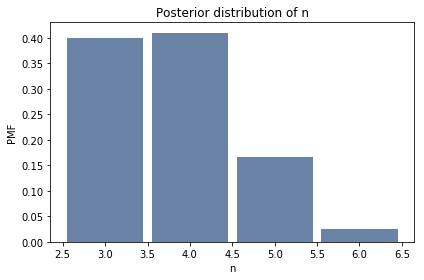

In [20]:
thinkplot.Hist(pmf_n)
print(pmf_n.Mean())
thinkplot.decorate(xlabel='n', 
                   ylabel='PMF', 
                   title='Posterior distribution of n')

Now, to answer the question, we have to compute the posterior distribution of the prevalence of elephants.  Here's a function that computes it.

In [21]:
def enumerate_posterior(suite):
    for d, p in suite.Items():
        mean = d.mean()
        index = d.label.find('E')
        p_elephant = 0 if index == -1 else mean[index]
        yield d, p, p_elephant

Here are the possible zoos, the posterior probability of each, and the conditional prevalence of elephants for each.

In [22]:
for d, p, p_elephant in enumerate_posterior(suite):
    print(d.label, p, p_elephant)

LTB 0.39926034376784497 0
LTBC 0.1364576975358686 0
LTBR 0.1365266963559979 0
LTBE 0.1369789254977338 0.1
LTBCR 0.057347250996821975 0
LTBCE 0.06027653795703476 0.09090909090909091
LTBRE 0.04856388605939697 0.09090909090909091
LTBCRE 0.02458866182930092 0.08333333333333333


Finally, we can use the law of total probability to compute the probability of seeing an elephant.

In [23]:
total = np.sum(p * p_elephant 
               for d, p, p_elephant in enumerate_posterior(suite))

0.02564153170370892